<a href="https://colab.research.google.com/github/yashraj02/CNN-Animals_Classification/blob/master/Animals_ShallowNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2 as cv
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

from keras.models import Sequential
from keras.layers import Conv2D,Activation,Flatten,Dense

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

In [0]:
from keras.datasets import cifar10

In [0]:
def shallowNet_model(width,height,depth,classes):
  print(width,height,depth,classes)
  model = Sequential()
  model.add(Conv2D(32,(3,3),padding='same',input_shape=(height,width,depth)))
  model.add(Activation('relu'))
  
  model.add(Flatten())
  model.add(Dense(classes))
  model.add(Activation('softmax'))
  
  return model

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float')/255.0
x_test = x_test.astype('float')/255.0

In [87]:
print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)


In [0]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [90]:
print("[INFO] compiling model...")
opti = SGD(lr=0.01)
model = shallowNet_model(32,32,3,10)
model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=['accuracy'])

print("[INFO] Training the Network...")
H = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=40, batch_size=32 ,verbose=1)

[INFO] compiling model...
32 32 3 10
[INFO] Training the Network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 44s 871us/step - loss: 1.7922 - accuracy: 0.3721 - val_loss: 1.6734 - val_accuracy: 0.4052
Epoch 2/40
50000/50000 [==============================] - 44s 872us/step - loss: 1.5260 - accuracy: 0.4681 - val_loss: 1.4216 - val_accuracy: 0.5059
Epoch 3/40
50000/50000 [==============================] - 44s 883us/step - loss: 1.3826 - accuracy: 0.5160 - val_loss: 1.3816 - val_accuracy: 0.5043
Epoch 4/40
50000/50000 [==============================] - 43s 866us/step - loss: 1.2995 - accuracy: 0.5437 - val_loss: 1.3431 - val_accuracy: 0.5151
Epoch 5/40
50000/50000 [==============================] - 44s 876us/step - loss: 1.2473 - accuracy: 0.5644 - val_loss: 1.4034 - val_accuracy: 0.5210
Epoch 6/40
50000/50000 [==============================] - 43s 863us/step - loss: 1.2108 - accuracy: 0.5780 - val_loss: 1.3399 - val_accur

In [91]:
print("[INFO] evaulating network...")
predictions = model.predict(x_test,batch_size=32)
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1),target_names=["airplane", "automobile", "bird", "cat", "deer",
                                                                                           "dog", "frog", "horse", "ship", "truck"]))

[INFO] evaulating network...
              precision    recall  f1-score   support

    airplane       0.69      0.61      0.65      1000
  automobile       0.80      0.62      0.70      1000
        bird       0.53      0.31      0.39      1000
         cat       0.33      0.63      0.43      1000
        deer       0.54      0.52      0.53      1000
         dog       0.47      0.52      0.49      1000
        frog       0.75      0.56      0.64      1000
       horse       0.72      0.62      0.67      1000
        ship       0.72      0.77      0.74      1000
       truck       0.65      0.71      0.68      1000

    accuracy                           0.59     10000
   macro avg       0.62      0.59      0.59     10000
weighted avg       0.62      0.59      0.59     10000



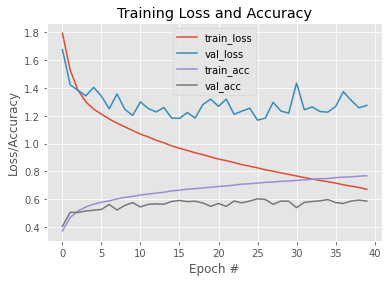

In [93]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**Conclusion:**
#  Our training and testing loss/accuracy start to diverge past epoch 10.
#  Again, this can be attributed to a larger learning rate and the fact we aren’t using methods to help combat overfitting (regularization parameters, dropout, data augmentation, etc.).